In [1]:
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using IntervalSets
using Random 
using ArraysOfArrays
using ValueShapes
using Measurements
using BAT 
using MultivariateStats
using Clustering
using PyPlot

# PDF:

In [2]:
Σ = [3.426818298733095 12.378238116671048 -9.632531611142456; 
    12.378238116671048 69.83909693165143 -43.478993858310886; 
    -9.632531611142456 -43.478993858310886 60.0626256206892]

μ = [8.959570984309234, -9.021529871694005, -5.007789383392622]

n_dims = 3 

distribution = MvNormal(μ, Σ)

prior = NamedTupleDist(
    x = repeat([-50.0 .. 50.0], n_dims),
);

In [3]:
n_dims = 30

distribution = BAT.FunnelDistribution(n=n_dims)

prior = NamedTupleDist(
    x = repeat([-50.0 .. 50.0], n_dims),
);

# MCMC Sampling: 

In [4]:
log_likelihood = let dist = distribution
    params -> begin
        LogDVal(logpdf(dist, params.x))
    end
end

posterior = PosteriorDensity(log_likelihood, prior);

In [5]:
nsamples = 10^6

# samples = bat_sample(
#     posterior, 
#     nsamples, MCMCSampling(sampler = MetropolisHastings(), nchains = 4)
# ).result; # MCMCSampling(sampler = MetropolisHastings(), nchains = 4)

samples = bat_sample(
    distribution, 
    nsamples, IIDSampling()).result; 

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44


In [6]:
i_ahmi = log(bat_integrate(samples).result)

┌ Info: Using integration algorithm AHMIntegration{CholeskyPartialWhitening,GeyerAutocorLen}
│   whitening: CholeskyPartialWhitening CholeskyPartialWhitening()
│   autocorlen: GeyerAutocorLen GeyerAutocorLen()
│   volumetype: Symbol HyperRectangle
│   max_startingIDs: Int64 10000
│   max_startingIDs_fraction: Float64 2.5
│   rect_increase: Float64 0.1
│   warning_minstartingids: Int64 16
│   dotrimming: Bool true
│   uncertainty: Array{Symbol}((1,))
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	500000 / 499999	Parameters:	30
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:93
┌ Info: Data Whitening.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:108
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic

LoadError: Created zero integration volumes. Try changing integration settings.

# Functions: 

In [20]:
function find_steep_edges(smpl::AbstractArray, w::AbstractArray; α=0.01)
    hist_weights = fit(Histogram, smpl, weights(w), nbins=100).weights
    max_weight = maximum(hist_weights)
    if hist_weights[1] < α*max_weight && hist_weights[end] < α*max_weight
        return false
    else
        return true
    end
end


function find_whiten_trans(smpl::AbstractArray, w::AbstractArray; edges=zeros(Bool, size(smpl)[1]))
      
    μ = mean(smpl, dims=2)
    
    cov_m = cov(smpl .- μ, FrequencyWeights(w), 2)
    
    for (ind, edge) in enumerate(edges)
        if edge 
            tmp_vals = cov_m[ind,ind]
            cov_m[:,ind] .= 0.0
            cov_m[ind,:] .= 0.0
            cov_m[ind,ind] = tmp_vals
        end
    end
    
    L = eigvals(cov_m)
    E = eigvecs(cov_m)
    W = E'
    W = W ./ sqrt.(L .+ 1e-4)
    
    return(W = W, μ=μ)
    
end

function apply_whiten_trans(smpl::AbstractArray, W::AbstractMatrix, μ::AbstractArray)
    return W*(smpl .- μ)
end

function apply_clustering(smpl::AbstractArray, w::AbstractArray, n_clusters::Integer)
    return kmeans(smpl, n_clusters, weights=w)
end

function find_volume(smpl::AbstractArray, w::AbstractArray, ll::AbstractArray, clust_center::AbstractArray)
    size_cube = 1.
    vol = (2*size_cube)^size(smpl)[1]
    mask = prod(-size_cube .< smpl .< size_cube, dims=1 )[1,:]
    return(mask = mask, vol = vol)
end

function compute_hm(smpl::AbstractArray, w::AbstractArray, ll::AbstractArray, mask::AbstractArray, vol::AbstractFloat, det1::AbstractFloat, det2::AbstractFloat)
    r = sum(w[mask]) / sum(w) 
    x = mean(1 ./ exp.(ll[mask]), weights(w[mask]))
    i_r = vol / (x*det1*det2)
    
    return  i_r / r
end

compute_hm (generic function with 1 method)

## Integration: 

In [64]:
smpl_v

30×1000000 Array{Float64,2}:
 -1.29875      2.30453    -0.122879   …  -1.04427    -0.952297    0.167999
  0.0324608   -3.97522    -0.0983179      0.033005    0.264245   -0.34035
 -0.0323793    2.03175    -0.419899      -0.311039   -0.0193052  -0.114828
  0.266268    -0.721266   -0.194002      -0.217155    0.195344   -0.178876
  0.00534955   0.690207   -0.141305      -0.223803   -0.0956791   0.654715
  0.0910112   -2.60271     0.339957   …   0.207888   -0.0119456   0.39711
  0.0425973    5.23836     0.178848       0.035104    0.0478049  -0.499151
 -0.0288649   -3.33405     0.481266       0.141451   -0.0845446   0.3367
 -0.15555      2.73243    -0.862947       0.0577123   0.0149967   0.2855
 -0.18168     -0.284207    0.160987       0.0256291   0.232669    0.228352
 -0.0989946   -3.88722     0.091494   …  -0.321532    0.0201597   0.489496
 -0.21024      1.76441    -0.201753       0.146484   -0.0450318   0.336023
  0.057969     1.85758    -0.248046       0.0589338  -0.0275953   0.332538
  

In [63]:
typeof(flatview(unshaped.(samples.v))) <: AbstractArray{AbstractFloat}

false

In [68]:
smpl_v = collect(flatview(unshaped.(samples.v)))
smpl_w = samples.weight

log_d_minimum = minimum(samples.logd )
smpl_ld = samples.logd .- log_d_minimum # subtract constant pedestal;

# *** initialize samples: 

steep_edges = [find_steep_edges(row, smpl_w) for row in eachrow(smpl_v)]
whiten_init_w, whiten_init_μ = find_whiten_trans(smpl_v, smpl_w, edges=steep_edges)
smpl_v = apply_whiten_trans(smpl_v, whiten_init_w, whiten_init_μ)

integral_estimates = Float64[]
samples_subspaes = []
samples_volumes= []
samples_clusters = []

n_clusters = 1

clusters = apply_clustering(smpl_v, smpl_w, n_clusters)

for clust_ind in 1:n_clusters
    mask_cluster = clusters.assignments .== clust_ind
    whiten_tmp_w, whiten_tmp_μ = find_whiten_trans(smpl_v[:,mask_cluster], smpl_w[mask_cluster]) #edges=steep_edges
    smpl_tmp = apply_whiten_trans(smpl_v, whiten_tmp_w, whiten_tmp_μ)

    cluster_center = whiten_tmp_w * clusters.centers[:,clust_ind]
    mask_volume, volume = find_volume(smpl_tmp[:,mask_cluster], smpl_w[mask_cluster], smpl_ld[mask_cluster], cluster_center)

    push!(samples_subspaes, smpl_tmp[:,mask_cluster])
    mask_cluster[mask_cluster .== 1] .= mask_volume
    hm_estimate = compute_hm(smpl_tmp, smpl_w, smpl_ld, mask_cluster, volume, abs(det(whiten_init_w)), abs(det(whiten_tmp_w)))
    
    hm_estimate = log(hm_estimate) + log_d_minimum
    
    push!(integral_estimates, hm_estimate)
    push!(samples_volumes, [mask_cluster])
    push!(samples_clusters, [mask_volume]) 
end



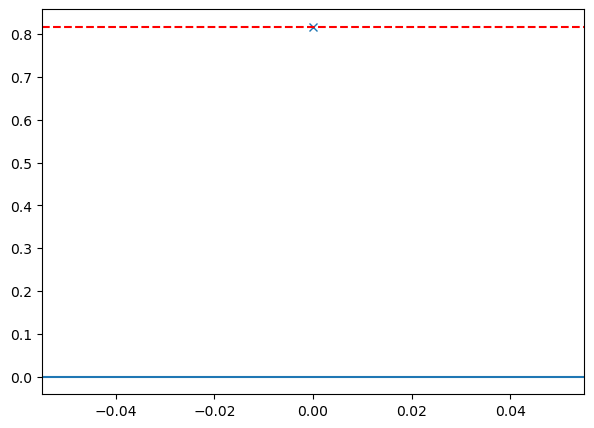

PyObject <matplotlib.lines.Line2D object at 0x7fb2a84bd520>

In [32]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(integral_estimates, "x")

# ax.set_ylim(-1, 1)
ax.axhline([0], )
ax.axhline([mean(integral_estimates)], color="red", linestyle = "--")

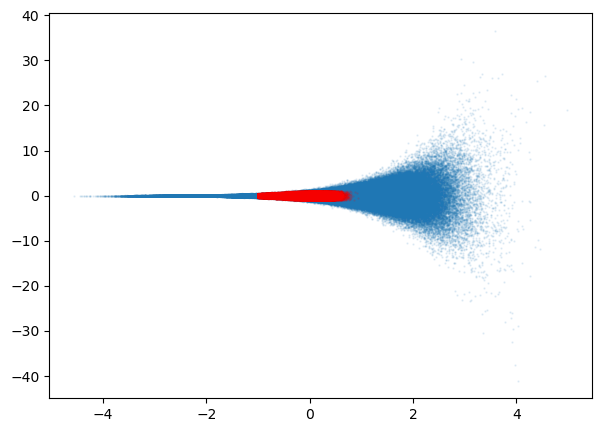

In [33]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.scatter(smpl_v[1,:], smpl_v[2,:], color="C0", alpha=0.1, s=0.5,)

for iii in samples_volumes
    ax.scatter(smpl_v[1,iii...], smpl_v[2,iii...], color="red", s=0.7,  alpha=0.1)
end

In [34]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ii = 10

ax.scatter(samples_subspaes[ii][1,:], samples_subspaes[ii][2,:], color="C0", alpha=0.1)

ax.scatter(samples_subspaes[ii][1,samples_clusters[ii]...], samples_subspaes[ii][2,samples_clusters[ii]...], color="red", alpha=0.1)

LoadError: BoundsError: attempt to access 1-element Array{Any,1} at index [10]

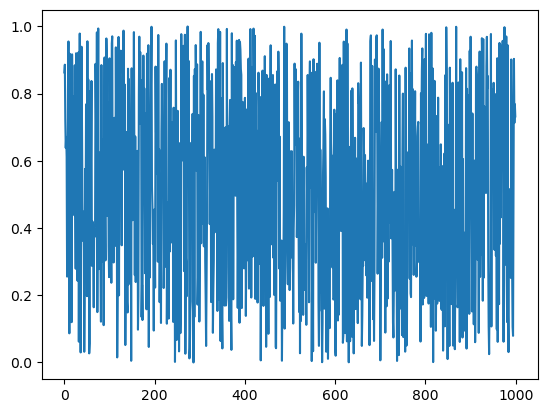

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb33d8c5190>

In [35]:
x = rand(Uniform(0, 1), 10^3)

plt.plot(x)

In [36]:
std(x)

0.2885114760472003